In [1]:
!pip install geopy

import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
import geopandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.utils import to_categorical

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

error_metric_used = 'mean_squared_error'
optimizer = tf.optimizers.Adam()

In [2]:
BASE_EPOCHS = 100

# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data. 
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion. 
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions. 
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy. 
    <li> You load a trained model. There's no training here. 
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work. 
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps. 
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



In [3]:
# Load data
df = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_num,1296675.0,NaN,NaN,NaN,417192042079641088.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
first,1296675,352,Christopher,26669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,1296675,481,Smith,28794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street,1296675,983,0069 Robin Brooks Apt. 695,3123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deal with Lat/Lon

We can utilize lat/lon of the home and merchant in a useful way?

Note: I left the section headers in from when I did it. You can remove them if you want. 

In [4]:
# Distance between home and merchant
df['home_loc'] = geopandas.points_from_xy(df['long'], df['lat'])
df['merch_loc'] = geopandas.points_from_xy(df['merch_long'], df['merch_lat'])

df['merch_distance'] = df.apply(lambda row: row['home_loc'].distance(row['merch_loc']), axis=1)

df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long', 'home_loc', 'merch_loc'], inplace=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,dob,trans_num,unix_time,is_fraud,merch_distance
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,0,0.872830
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,0,0.272310
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,0,0.975845
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,0,0.919802
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,0,0.868505


### Deal with Time

Can we make date/time and the date of birth into something useful?

In [5]:
# Age of person on transaction date
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

df['user_age'] = (df['trans_date_trans_time'] - df['dob']).dt.days
df.drop(columns=['dob'], inplace=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,city_pop,job,trans_num,unix_time,is_fraud,merch_distance,user_age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,0,0.872830,11255
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,0,0.272310,14804
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,0,0.975845,20801
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,0,0.919802,18982
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,0,0.868505,11967


In [6]:
# Keep only the time of the transaction
df['time'] = df['trans_date_trans_time'].dt.time
# Change time to minutes
df['time'] = df['time'].apply(lambda x: x.hour * 60 + x.minute)

# Drop columns
df.drop(columns=['trans_date_trans_time'], inplace=True)

### Check Target Balance

In [7]:
neg, pos = np.bincount(df['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



In [12]:
# Calculate class weights
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

### Prepare Data


In [8]:
cleaned_df = df.copy()
cleaned_df.drop(columns=['cc_num', 'merchant', 'first',	'last', 'street','city','zip', 'state','job', 'trans_num', 'unix_time'], inplace=True)

scaler = StandardScaler()
num = ['amt', 'city_pop', 'merch_distance', 'user_age', 'time']
scaler.fit(cleaned_df[num])
cleaned_df[num] = scaler.transform(cleaned_df[num])

new_df = pd.get_dummies(cleaned_df)

### Split Data

In [9]:
y = new_df["is_fraud"]
X = new_df.drop(columns={"is_fraud"})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)


### Model

In [10]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(21, input_shape=(21,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(21, input_shape=(21,), activation='relu', kernel_regularizer="l1"))
model.add(Dense(21, input_shape=(21,), activation='relu', kernel_regularizer="l2"))
model.add(Dense(1))
model.summary()

c:\Users\desla\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ ?                      │            43 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43 (176.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 43 (176.00 B)

Epoch 1/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0864 - val_loss: 0.0064
Epoch 2/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 3/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 4/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 5/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 6/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 7/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 9/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 10/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 11/100
8299/8299 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 12

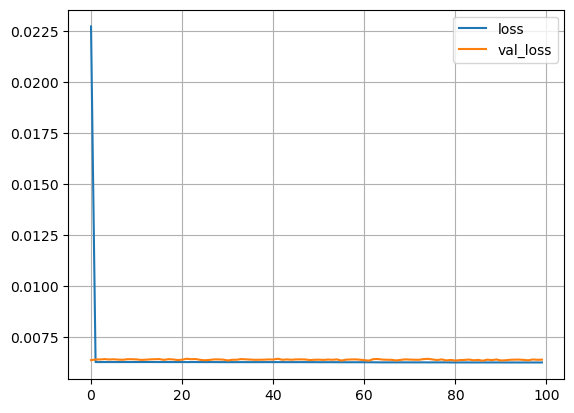

In [15]:
model.compile(loss=error_metric_used, optimizer=optimizer)

train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BASE_EPOCHS, validation_split=.2, verbose=1)
model.evaluate(X_test, y_test)
plot_loss(train_log)

In [17]:
model.save('my_model.keras')